# Pokemon Sprites Generator VAE

In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm
import keras
import tensorflow as tf
from tensorflow.keras import layers
from keras.models import Sequential, Model, Input
from tensorflow.keras import losses
from PIL import Image

In [2]:
# GPU SESSION ACTIVATION
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
session =tf.compat.v1.InteractiveSession(config=config)

In [16]:
#LOADING THE DATA INTO A NUMPY ARRAY

dir_data = r'C:\Users\Alessio\Machine Learning Exercises\datasets\pk_sprites/'
pk_sprites = []
for img in tqdm(os.listdir(dir_data)):
    path = dir_data+'{}'.format(img)
    
    image = plt.imread(path)
    image = image.astype('float32')
    #image = image[:, :, :3] # removing transparancy png
    pk_sprites.append(image)
    
    
pk_sprites = np.array(pk_sprites)  

100%|██████████| 12158/12158 [00:03<00:00, 3571.76it/s]


In [17]:
print(pk_sprites.shape)

(12158, 64, 64, 4)


In [18]:
# Model

latent_dims = 512
epochs = 50
batch_size = 64

class CVAE(tf.keras.Model):
  """Convolutional variational autoencoder."""

  def __init__(self, latent_dim):
    super(CVAE, self).__init__()
    self.latent_dim = latent_dim
    self.encoder = tf.keras.Sequential(
        [
            tf.keras.layers.InputLayer(input_shape=(64, 64, 4)),
            tf.keras.layers.Conv2D(
                filters=32, kernel_size=5,strides=1, activation='relu'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Conv2D(
                filters=64, kernel_size=5, strides=(2, 2), activation='relu'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Conv2D(
                filters=128, kernel_size=5, strides=(2, 2), activation='relu'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Conv2D(
                filters=256, kernel_size=5, strides=(2, 2), activation='relu'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Conv2D(
                filters=512, kernel_size=3, strides=(2, 2), activation='relu'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(latent_dim),
            tf.keras.layers.BatchNormalization(),
        ])

    self.decoder = tf.keras.Sequential(
        [
            tf.keras.layers.InputLayer(input_shape=(latent_dim,)),
            tf.keras.layers.Dense(units=4*4*512, activation=tf.nn.relu),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Reshape(target_shape=(4, 4, 512)),
            tf.keras.layers.Conv2DTranspose(
                filters=256, kernel_size=5, strides=2, padding='same',
                activation='relu'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Conv2DTranspose(
                filters=128, kernel_size=5, strides=2, padding='same',
                activation='relu'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Conv2DTranspose(
                filters=64, kernel_size=5, strides=2, padding='same',
                activation='relu'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Conv2DTranspose(
                filters=32, kernel_size=5, strides=2, padding='same',
                activation='relu'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Conv2DTranspose(
                filters=4, kernel_size=3, strides=1, padding='same',
                activation='sigmoid'),
            tf.keras.layers.BatchNormalization(),
        ])

  @tf.function
  def sample(self, eps=None):
    if eps is None:
      eps = tf.random.normal(shape=(100, self.latent_dim))
    return self.decode(eps, apply_sigmoid=True)

  def encode(self, x):
    mean, logvar = tf.split(self.encoder(x), num_or_size_splits=2, axis=1)
    return mean, logvar

  def reparameterize(self, mean, logvar):
    eps = tf.random.normal(shape=mean.shape)
    return eps * tf.exp(logvar * .5) + mean

  def decode(self, z, apply_sigmoid=False):
    logits = self.decoder(z)
    if apply_sigmoid:
      probs = tf.sigmoid(logits)
      return probs
    return logits


  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

vae = CVAE(latent_dims)

In [19]:
optimizer = tf.keras.optimizers.Adam(1e-4)


def log_normal_pdf(sample, mean, logvar, raxis=1):
  log2pi = tf.math.log(2. * np.pi)
  return tf.reduce_sum(
      -.5 * ((sample - mean) ** 2. * tf.exp(-logvar) + logvar + log2pi),
      axis=raxis)


def compute_loss(model, x):
  mean, logvar = model.encode(x)
  z = model.reparameterize(mean, logvar)
  x_logit = model.decode(z)
  cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=x)
  logpx_z = -tf.reduce_sum(cross_ent, axis=[1, 2, 3])
  logpz = log_normal_pdf(z, 0., 0.)
  logqz_x = log_normal_pdf(z, mean, logvar)
  return -tf.reduce_mean(logpx_z + logpz - logqz_x)


@tf.function
def train_step(model, x, optimizer):
  """Executes one training step and returns the loss.

  This function computes the loss and gradients, and uses the latter to
  update the model's parameters.
  """
  with tf.GradientTape() as tape:
    loss = compute_loss(model, x)
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))

In [20]:
# COMPILE AND MODEL FIT
vae.compile(optimizer='adam', loss=losses.MeanSquaredError(), metrics=['accuracy'])

In [21]:
history = vae.fit(pk_sprites,pk_sprites, epochs=50, batch_size=64, verbose=1)

Epoch 1/50
190/190 [==============================] - 7s 30ms/step - loss: 0.4510 - accuracy: 0.2873
Epoch 2/50
190/190 [==============================] - 6s 30ms/step - loss: 0.2127 - accuracy: 0.3463
Epoch 3/50
190/190 [==============================] - 6s 30ms/step - loss: 0.1055 - accuracy: 0.4034
Epoch 4/50
190/190 [==============================] - 6s 30ms/step - loss: 0.0593 - accuracy: 0.5016
Epoch 5/50
190/190 [==============================] - 6s 30ms/step - loss: 0.0416 - accuracy: 0.5908
Epoch 6/50
190/190 [==============================] - 6s 30ms/step - loss: 0.0349 - accuracy: 0.5667
Epoch 7/50
190/190 [==============================] - 6s 30ms/step - loss: 0.0319 - accuracy: 0.5254
Epoch 8/50
190/190 [==============================] - 6s 30ms/step - loss: 0.0305 - accuracy: 0.5182
Epoch 9/50
190/190 [==============================] - 6s 30ms/step - loss: 0.0290 - accuracy: 0.5082
Epoch 10/50
190/190 [==============================] - 6s 30ms/step - loss: 0.0278 - accura

In [22]:
#vae.build((None,64,64,4))
vae.summary()

Model: "cvae_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_2 (Sequential)    (None, 512)               2527712   
_________________________________________________________________
sequential_3 (Sequential)    (None, 64, 64, 4)         8590836   
Total params: 11,118,548
Trainable params: 11,098,188
Non-trainable params: 20,360
_________________________________________________________________


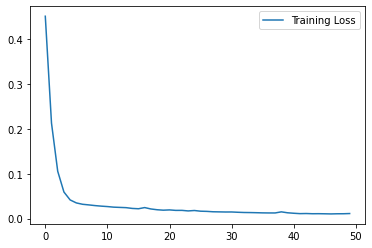

In [23]:
# LOSS PLOT
plt.plot(history.history["loss"], label="Training Loss")
plt.legend()

In [24]:
def plot_images(rows, cols, images, title):
    grid = np.zeros(shape=(rows*64, cols*64, 4))
    for row in range(rows):
        for col in range(cols):
            #images = images / images.max(axis=0)
            #images = images / 255
            grid[row*64:(row+1)*64, col*64:(col+1)*64, :] = images[row*cols + col]

    plt.figure(figsize=(20,20))       
    plt.imshow(grid)
    plt.title(title)
    plt.show()

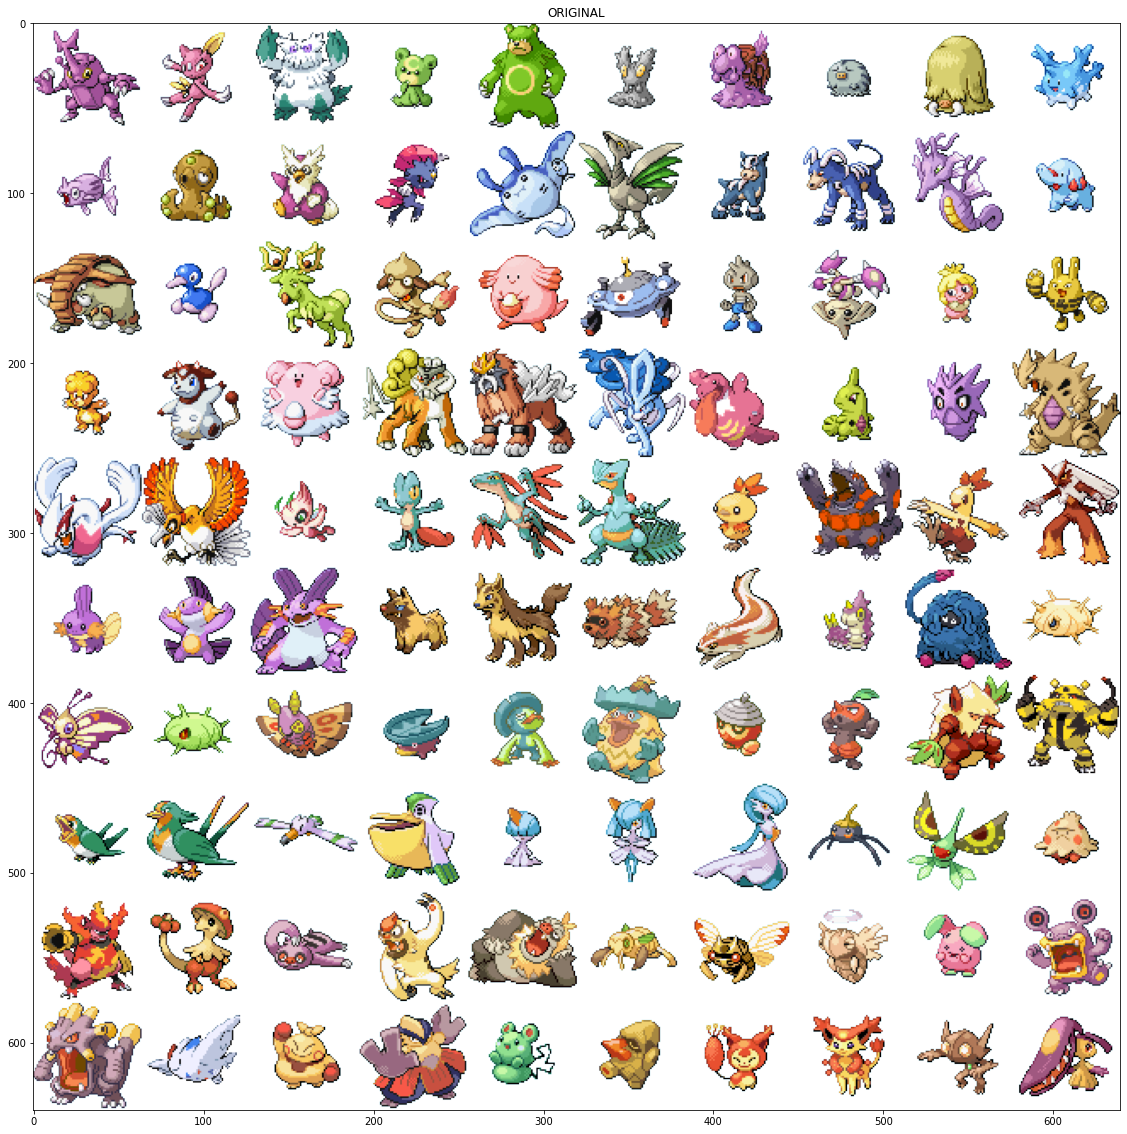

In [25]:
# ORIGINAL IMAGES
start_range = 200
fin_range = 300
predictions = pk_sprites[start_range:fin_range]
plot_images(10,10,predictions,"ORIGINAL")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


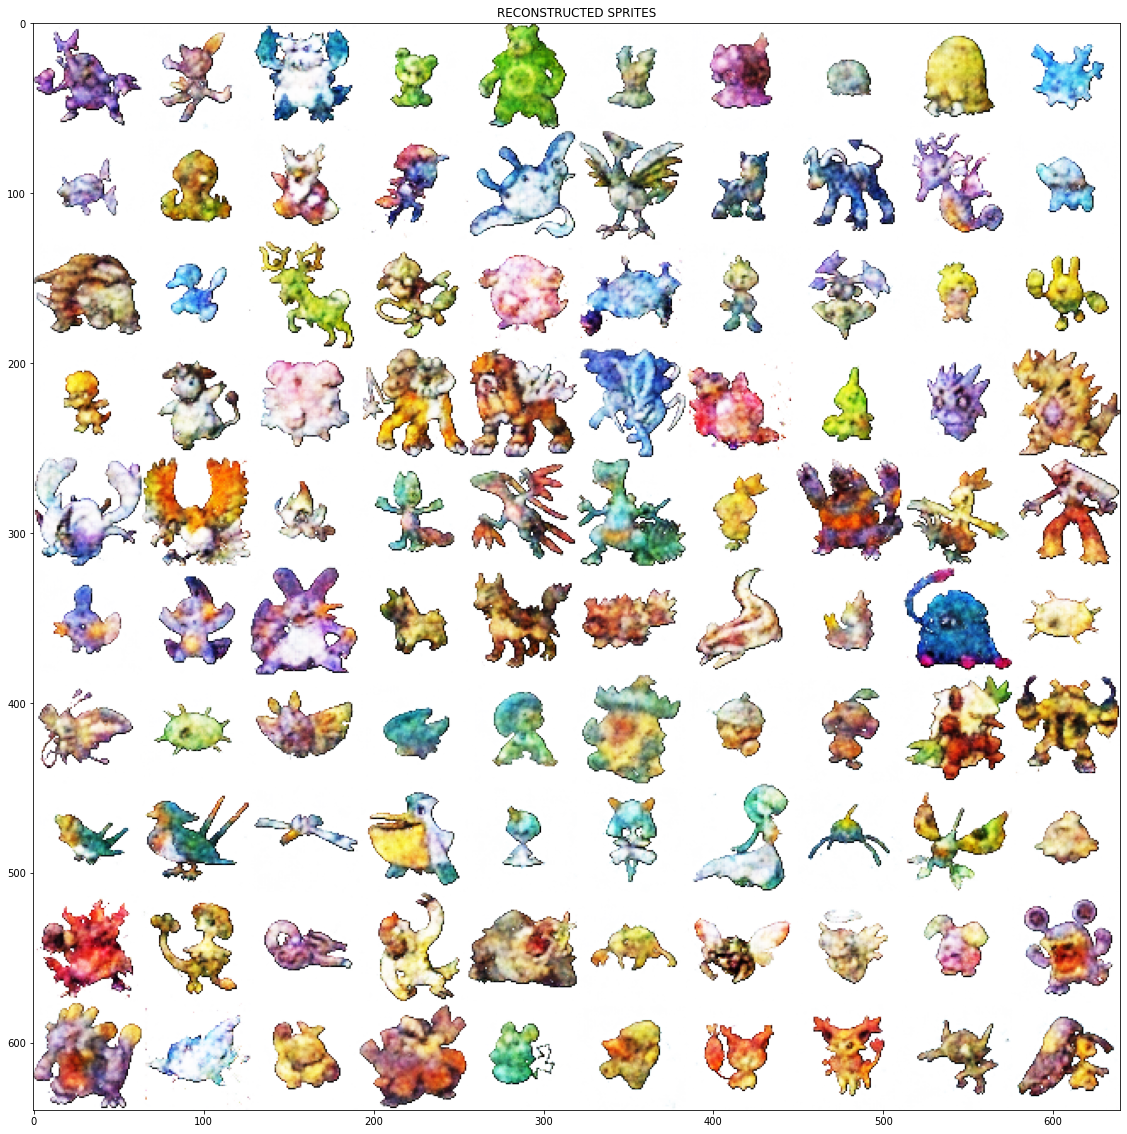

In [26]:
# RECONSTRUCTION OF ORIGINAL IMAGES

predictions  = vae.predict(pk_sprites[start_range:fin_range])
plot_images(10,10,predictions, "RECONSTRUCTED SPRITES")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


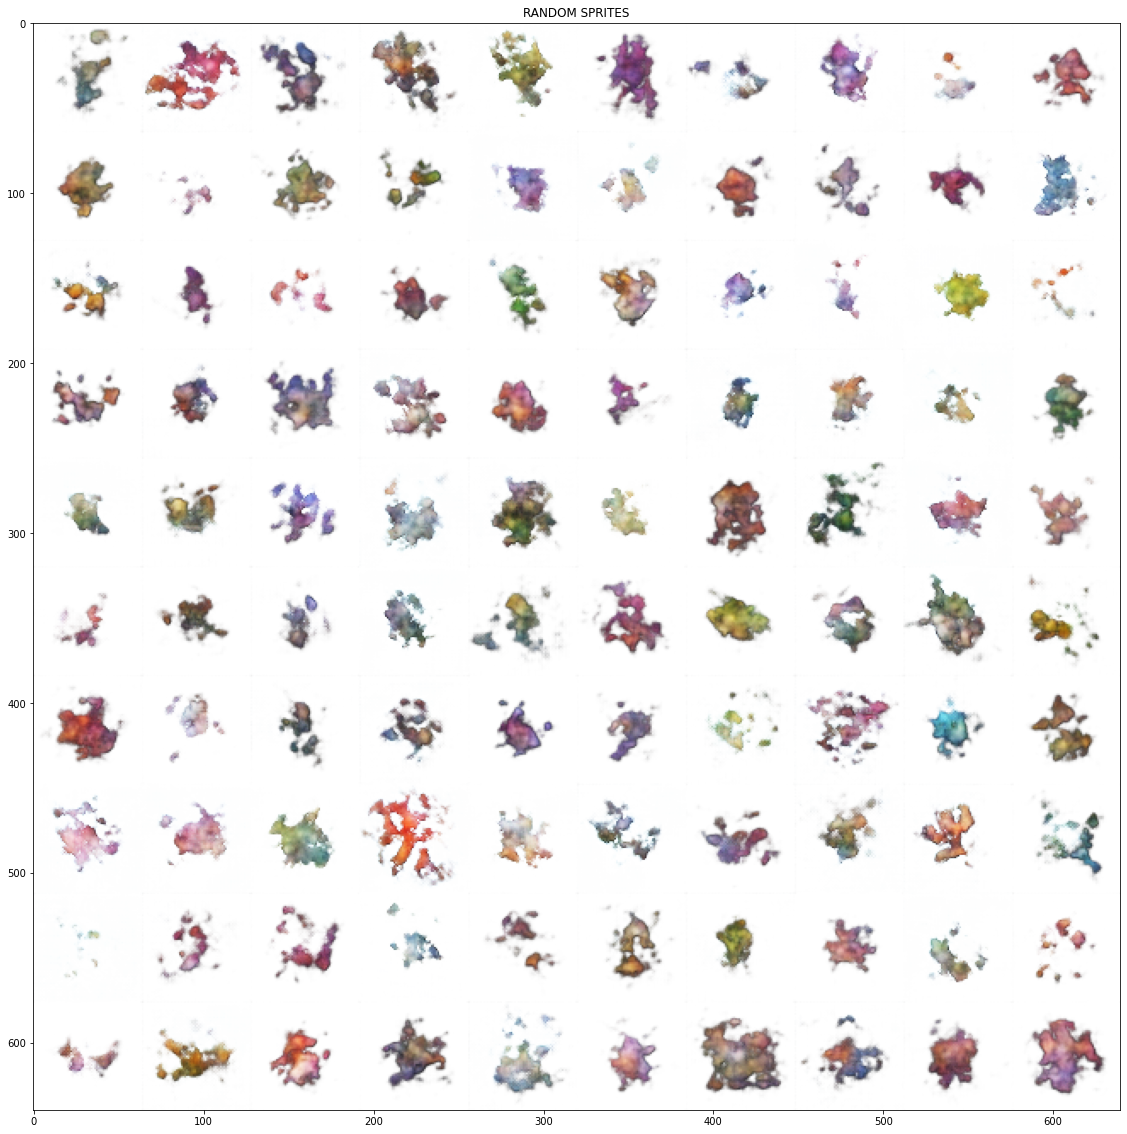

In [28]:
#NEW SPRITES GENERATED

predictions= vae.decoder.predict(np.random.randn(110, latent_dims))
plot_images(10,10,predictions, "RANDOM SPRITES")